In [2]:
include("../code/sp.jl")
include("../code/matrix_generator.jl")
include("../code/slim_graphs.jl")
include("../code/bp.jl")
using ProgressMeter, StaticArrays, OffsetArrays, Statistics

In [3]:
callback(t, ε, sp) = (println("$t $ε"); false)

function decimate!(sp, indep; decsteps=10, callback=callback)
    H = sp.H
    freevars = copy(indep)
    iteration!(sp, maxiter=700, tol=1e-5, callback=callback, damp=0.5)
    sp_pre = deepcopy(sp)
    while !isempty(freevars)
        iteration!(sp, maxiter=100, tol=1e-3, damp=0.5)
        mag = map(p->p'eachindex(p), sp.survey)
        sort!(freevars, by=i->abs(mag[i]))
        freevars, tofix = freevars[1:end-decsteps], freevars[max(1,end-decsteps+1):end]
        sp.efield[tofix] .= sp.J.*sign.(mag[tofix])
    end
    sp_pre
end

decimate! (generic function with 2 methods)

In [4]:
f1 = 0.01
f3s = 0.3:0.05:0.6
# f3s = 0.3:0.05:0.35
Rs = fill(NaN, eachindex(f3s))
navg = 10
D_sp = [fill(NaN, navg) for _ in f3s]
y = 0.5
n = 300
K = OffsetVector([0,0,0,1], 0:3)
mK = sum(k*K[k] for k=eachindex(K))
J = 20
sps_pre = [Vector{SurveyPropagation{Bool, OffsetVector{Float64, Vector{Float64}}}}(undef, navg) for _ in f3s];
sps_post = [Vector{SurveyPropagation{Bool, OffsetVector{Float64, Vector{Float64}}}}(undef, navg) for _ in f3s];
sources = [[falses(n) for _ in 1:navg] for _ in f3s];

for (i,f3) in pairs(f3s)
    println("--- degree $i of $(length(f3s)): f3 = $f3 ---")
    flush(stdout)
    Λ = OffsetVector([0,f1,1-f1-f3,f3], 0:3)
    mΛ = sum(d*Λ[d] for d=eachindex(Λ))
    α = mΛ/mK; Rs[i]=1-α
    # Single instance
    nedges = Int(round(n*sum(i*l for (i,l) in pairs(Λ)), digits=8))
    m = Int(nedges/3)
    dist = zeros(navg)
    for k in 1:navg
        println("Avg $k of $navg")
        Ht = ldpc_matrix(n, m, nedges, Λ, K)
        H = permutedims(Ht)
        B,indep = findbasis_slow(Array(H))
        x0 = bitrand(size(H,2))
        sources[i][k] = x0
        s = (-1) .^ x0
        init = OffsetArray(MVector{2J+1}(fill(0.0,2J+1)), -J:J)
        init[-1:1] .= 1/3
        sp = survey_propagation(H; field=copy(s), init=copy(init), y=y)
        sps_pre[i][k] = decimate!(sp, indep; decsteps=1, callback=(x...)->false)
        sps_post[i][k] = sp
        mag = sign.(map(p->p'eachindex(p), sp.survey))
        x = mag .== -1
        w = sparse(B*x[indep] .% 2)
        println("Nunsat = ", sum(H*x .% 2))
        D_sp[i][k] = mean(w .!= x0)
    end
end

--- degree 1 of 7: f3 = 0.3 ---
Avg 1 of 10
(ss, i) = (1.0984901271107599, 114)
(ss, i) = (1.0959207473014765, 114)
(ss, i) = (1.0934611795540097, 114)
(ss, i) = (1.0911979728068235, 114)
(ss, i) = (1.0891803362400039, 114)
(ss, i) = (1.0874271901408523, 114)
(ss, i) = (1.0859366865775544, 114)
(ss, i) = (1.0846951667610427, 114)
(ss, i) = (1.0836840802997234, 114)
(ss, i) = (1.0828845119818378, 114)
(ss, i) = (1.082279617307221, 114)
(ss, i) = (1.0818555505581464, 114)
(ss, i) = (1.0816014992682466, 114)
(ss, i) = (1.08150932629141, 114)
(ss, i) = (1.081573150000426, 114)
(ss, i) = (1.0817890223535316, 114)
(ss, i) = (1.082154728386481, 114)
(ss, i) = (1.08266964549098, 114)
(ss, i) = (1.0833345689062872, 114)
(ss, i) = (1.0841514231447988, 114)
(ss, i) = (1.08512282305682, 114)
(ss, i) = (1.086251505766886, 114)
(ss, i) = (1.0875397095071355, 114)
(ss, i) = (1.0889886144970211, 114)
(ss, i) = (1.090597976067524, 114)
(ss, i) = (1.092366067394437, 114)
(ss, i) = (1.0942900086693266, 1

(ss, i) = (1.0669335053364786, 32)
(ss, i) = (1.0971873547386926, 62)
(ss, i) = (1.0530370087497127, 141)
(ss, i) = (1.0976537253310408, 213)
(ss, i) = (1.0701722437724066, 32)
(ss, i) = (1.057697580585454, 141)
(ss, i) = (1.072565010448718, 32)
(ss, i) = (1.0625390478938257, 141)
(ss, i) = (1.0738505482997052, 32)
(ss, i) = (1.0670944038637626, 141)
(ss, i) = (1.074004366442073, 32)
(ss, i) = (1.07093884721237, 141)
(ss, i) = (1.0732055777611447, 32)
(ss, i) = (1.0891424249546728, 119)
(ss, i) = (1.0737760404303682, 141)
(ss, i) = (1.0717694395553987, 32)
(ss, i) = (1.0792556139383285, 119)
(ss, i) = (1.0754890392210157, 141)
(ss, i) = (1.0700685994208712, 32)
(ss, i) = (1.0712615235480274, 119)
(ss, i) = (1.0761435711771188, 141)
(ss, i) = (1.0684633301244568, 32)
(ss, i) = (1.0647623214742348, 119)
(ss, i) = (1.0759482279394805, 141)
(ss, i) = (1.0672525166662026, 32)
(ss, i) = (1.0595110160975054, 119)
(ss, i) = (1.0751879239464839, 141)
(ss, i) = (1.0666476151964572, 32)
(ss, i) =

(ss, i) = (1.0370194627983529, 32)
(ss, i) = (1.0224408383936763, 62)
(ss, i) = (1.0470369358367937, 66)
(ss, i) = (1.0518330434512948, 112)
(ss, i) = (1.0428037428466983, 114)
(ss, i) = (1.058898157867682, 119)
(ss, i) = (1.0080483685914459, 141)
(ss, i) = (1.049350837585859, 144)
(ss, i) = (1.0254212658372457, 153)
(ss, i) = (1.0620192367432701, 199)
(ss, i) = (1.05811446416183, 210)
(ss, i) = (1.0723259799781835, 257)
(ss, i) = (1.0577762996793794, 272)
(ss, i) = (1.0350515775349785, 32)
(ss, i) = (1.0969977017433066, 37)
(ss, i) = (1.017280073065574, 62)
(ss, i) = (1.0449500212423237, 66)
(ss, i) = (1.0547361523603032, 112)
(ss, i) = (1.0419442314338687, 114)
(ss, i) = (1.0668315783448727, 119)
(ss, i) = (1.006604227162999, 141)
(ss, i) = (1.0476377761555329, 144)
(ss, i) = (1.0195925149656242, 153)
(ss, i) = (1.056484323033298, 199)
(ss, i) = (1.0644634991327897, 210)
(ss, i) = (1.067848623017505, 257)
(ss, i) = (1.052772353820637, 272)
(ss, i) = (1.0330116981973572, 32)
(ss, i) =

(ss, i) = (1.019332277816677, 75)
(ss, i) = (1.0076627975829817, 76)
(ss, i) = (1.0627328819769446, 77)
(ss, i) = (1.0086720823712125, 91)
(ss, i) = (1.0411950145966546, 93)
(ss, i) = (1.0434474144601948, 114)
(ss, i) = (1.0672703376579684, 121)
(ss, i) = (1.005308513627684, 124)
(ss, i) = (1.004425742525795, 141)
(ss, i) = (1.0664498850070374, 144)
(ss, i) = (1.0727959688718827, 149)
(ss, i) = (1.0037413977626708, 153)
(ss, i) = (1.0790064285535352, 155)
(ss, i) = (1.0989078327162976, 191)
(ss, i) = (1.0301718869321792, 197)
(ss, i) = (1.0419489356226888, 198)
(ss, i) = (1.0782262840083925, 199)
(ss, i) = (1.0005715406124545, 213)
(ss, i) = (1.0177916942779384, 240)
(ss, i) = (1.058650677345276, 257)
(ss, i) = (1.088564128935578, 272)
(ss, i) = (1.0768965275807099, 1)
(ss, i) = (1.0088574308543783, 3)
(ss, i) = (1.041467546154434, 27)
(ss, i) = (1.0425432472625873, 29)
(ss, i) = (1.0152612990095642, 32)
(ss, i) = (1.0726549052022771, 34)
(ss, i) = (1.0375922686753543, 42)
(ss, i) = (1

(ss, i) = (1.0595491044486016, 93)
(ss, i) = (1.0237939586324343, 100)
(ss, i) = (1.0237939587297753, 104)
(ss, i) = (1.0319655791922386, 114)
(ss, i) = (1.0535795029446484, 121)
(ss, i) = (1.080159512977058, 123)
(ss, i) = (1.0036593292362461, 124)
(ss, i) = (1.0249042789798293, 137)
(ss, i) = (1.0095552801954923, 141)
(ss, i) = (1.0965864792045663, 144)
(ss, i) = (1.0495569815302463, 149)
(ss, i) = (1.0092308692252518, 153)
(ss, i) = (1.062159090464102, 155)
(ss, i) = (1.0148548624736045, 156)
(ss, i) = (1.0504750893072876, 169)
(ss, i) = (1.0232510855904744, 186)
(ss, i) = (1.0621276798109838, 191)
(ss, i) = (1.0066880123853645, 197)
(ss, i) = (1.0033927196053574, 198)
(ss, i) = (1.0637921541255557, 204)
(ss, i) = (1.021833508792238, 207)
(ss, i) = (1.0010499413361766, 213)
(ss, i) = (1.0092197428631278, 226)
(ss, i) = (1.0138771963835522, 240)
(ss, i) = (1.0870256768135853, 257)
(ss, i) = (1.049033149379464, 1)
(ss, i) = (1.02006438124022, 3)
(ss, i) = (1.0630190616338657, 27)
(ss,

(ss, i) = (1.0560503607795062, 178)
(ss, i) = (1.0011559273562256, 186)
(ss, i) = (1.033670471817228, 191)
(ss, i) = (1.0027078127241797, 197)
(ss, i) = (1.0014479898847026, 198)
(ss, i) = (1.0099688952654304, 204)
(ss, i) = (1.0056061411748267, 207)
(ss, i) = (1.0038883226759898, 213)
(ss, i) = (1.0630074857362595, 219)
(ss, i) = (1.0238504622792304, 225)
(ss, i) = (1.003916829112674, 226)
(ss, i) = (1.010511474647839, 240)
(ss, i) = (1.0301483896417736, 1)
(ss, i) = (1.0340997210833032, 3)
(ss, i) = (1.0916993581139698, 27)
(ss, i) = (1.0123789344937866, 29)
(ss, i) = (1.0074532511180243, 32)
(ss, i) = (1.040077822754061, 34)
(ss, i) = (1.0948958907918127, 35)
(ss, i) = (1.0145355150358026, 42)
(ss, i) = (1.0102262491768974, 43)
(ss, i) = (1.0075372372000555, 44)
(ss, i) = (1.0214947613318797, 45)
(ss, i) = (1.0019681622415268, 50)
(ss, i) = (1.0276039149085994, 52)
(ss, i) = (1.007428533513272, 60)
(ss, i) = (1.096894576092741, 61)
(ss, i) = (1.0050260153559896, 62)
(ss, i) = (1.036

(ss, i) = (1.0002218397151093, 73)
(ss, i) = (1.0309545438642453, 75)
(ss, i) = (1.0316064445082558, 76)
(ss, i) = (1.0006587453286284, 77)
(ss, i) = (1.0116273299736362, 78)
(ss, i) = (1.0666677129513467, 90)
(ss, i) = (1.032035601428464, 91)
(ss, i) = (1.0742748613012956, 96)
(ss, i) = (1.015245556467423, 100)
(ss, i) = (1.0152455564500407, 104)
(ss, i) = (1.0715551098754867, 109)
(ss, i) = (1.0107878629496747, 114)
(ss, i) = (1.0322590887228584, 116)
(ss, i) = (1.029081656274578, 121)
(ss, i) = (1.0133829707408963, 123)
(ss, i) = (1.0004044889433714, 124)
(ss, i) = (1.0529298929904434, 126)
(ss, i) = (1.060997964091422, 137)
(ss, i) = (1.005457728749794, 141)
(ss, i) = (1.025272325156889, 149)
(ss, i) = (1.008904394153751, 153)
(ss, i) = (1.0339640174613132, 155)
(ss, i) = (1.0017882039757204, 156)
(ss, i) = (1.0864934382400981, 164)
(ss, i) = (1.0093278672494184, 167)
(ss, i) = (1.0108365971937365, 169)
(ss, i) = (1.0266727476813626, 178)
(ss, i) = (1.0006030223823275, 186)
(ss, i)

(ss, i) = (1.0238259862054013, 35)
(ss, i) = (1.046787493289895, 37)
(ss, i) = (1.0640501591871547, 41)
(ss, i) = (1.017041944390682, 42)
(ss, i) = (1.014378160246602, 43)
(ss, i) = (1.0045537106379705, 44)
(ss, i) = (1.004778865238322, 45)
(ss, i) = (1.0051805130527927, 50)
(ss, i) = (1.0386363614858656, 52)
(ss, i) = (1.0038106114917698, 60)
(ss, i) = (1.078975916850675, 61)
(ss, i) = (1.0035866816732733, 62)
(ss, i) = (1.0134102008215353, 66)
(ss, i) = (1.0003051575748376, 73)
(ss, i) = (1.04012608963191, 75)
(ss, i) = (1.0260300825450421, 76)
(ss, i) = (1.0011151317777576, 77)
(ss, i) = (1.004860310383116, 78)
(ss, i) = (1.0304126209249642, 91)
(ss, i) = (1.0959611471405295, 93)
(ss, i) = (1.0739029693146211, 96)
(ss, i) = (1.0284098959063652, 100)
(ss, i) = (1.028409895881458, 104)
(ss, i) = (1.0089580265847153, 114)
(ss, i) = (1.0322991163779094, 116)
(ss, i) = (1.0306870818404839, 121)
(ss, i) = (1.0070055554961992, 123)
(ss, i) = (1.0001839561229207, 124)
(ss, i) = (1.021226128

(ss, i) = (1.0132217037891962, 204)
(ss, i) = (1.0005849415682841, 207)
(ss, i) = (1.0028893049955365, 213)
(ss, i) = (1.0396832691502307, 219)
(ss, i) = (1.0810134509349267, 225)
(ss, i) = (1.016725551546437, 226)
(ss, i) = (1.0125190565507758, 240)
(ss, i) = (1.0223051255800775, 1)
(ss, i) = (1.021607772567849, 3)
(ss, i) = (1.0487231553846075, 8)
(ss, i) = (1.0716667677046678, 17)
(ss, i) = (1.088777609548012, 18)
(ss, i) = (1.0350210235384492, 19)
(ss, i) = (1.0599481585090922, 27)
(ss, i) = (1.038956407675646, 29)
(ss, i) = (1.094951186415684, 31)
(ss, i) = (1.0084068769277748, 32)
(ss, i) = (1.0343070936671737, 34)
(ss, i) = (1.0104087064414942, 35)
(ss, i) = (1.030977761287835, 37)
(ss, i) = (1.038533379741907, 41)
(ss, i) = (1.0199670852281355, 42)
(ss, i) = (1.011058656989748, 43)
(ss, i) = (1.0059253284895602, 44)
(ss, i) = (1.0021682074956655, 45)
(ss, i) = (1.0069481155158047, 50)
(ss, i) = (1.0516814808963926, 52)
(ss, i) = (1.005654328916029, 60)
(ss, i) = (1.067216112798

(ss, i) = (1.0299772025966818, 164)
(ss, i) = (1.0010468350301536, 167)
(ss, i) = (1.0015016308689442, 169)
(ss, i) = (1.0123507000532175, 171)
(ss, i) = (1.0026615993313719, 178)
(ss, i) = (1.0021263083817629, 186)
(ss, i) = (1.0591160542224758, 191)
(ss, i) = (1.0888185940692798, 192)
(ss, i) = (1.0002919039448557, 197)
(ss, i) = (1.0080911570132842, 198)
(ss, i) = (1.0186209809234688, 204)
(ss, i) = (1.000645346597818, 207)
(ss, i) = (1.0823244642188117, 208)
(ss, i) = (1.0022053615140616, 213)
(ss, i) = (1.0570740626757276, 219)
(ss, i) = (1.0213467381388228, 226)
(ss, i) = (1.0165772599694745, 240)
(ss, i) = (1.0287780467557246, 1)
(ss, i) = (1.0226985870010412, 3)
(ss, i) = (1.0264846639246337, 8)
(ss, i) = (1.0702358429259478, 17)
(ss, i) = (1.0128123760949688, 19)
(ss, i) = (1.0530678149951942, 27)
(ss, i) = (1.0333417172913144, 29)
(ss, i) = (1.0113951549636786, 32)
(ss, i) = (1.0351195940828564, 34)
(ss, i) = (1.0065996774036787, 35)
(ss, i) = (1.0301900529010257, 37)
(ss, i)

(ss, i) = (1.028829451835354, 42)
(ss, i) = (1.0067302863550398, 43)
(ss, i) = (1.0088283162250915, 44)
(ss, i) = (1.0025735855822835, 45)
(ss, i) = (1.0061758139215202, 50)
(ss, i) = (1.0784819115369468, 52)
(ss, i) = (1.09708504822856, 56)
(ss, i) = (1.0105738204892154, 60)
(ss, i) = (1.0493337355294858, 61)
(ss, i) = (1.0042920051714865, 62)
(ss, i) = (1.0145024846591997, 66)
(ss, i) = (1.0010591185157205, 73)
(ss, i) = (1.0218388910955165, 75)
(ss, i) = (1.0284384016112653, 76)
(ss, i) = (1.0032234659552561, 77)
(ss, i) = (1.0031431674855609, 78)
(ss, i) = (1.0624323354582303, 83)
(ss, i) = (1.0291379927106494, 91)
(ss, i) = (1.056859165112366, 93)
(ss, i) = (1.0920785016488086, 96)
(ss, i) = (1.0644594069375444, 98)
(ss, i) = (1.032389158818769, 100)
(ss, i) = (1.0323891588194727, 104)
(ss, i) = (1.011930630143557, 114)
(ss, i) = (1.078739547616119, 116)
(ss, i) = (1.0395022342104463, 121)
(ss, i) = (1.0017558239216042, 123)
(ss, i) = (1.0004480762746695, 124)
(ss, i) = (1.0046648

(ss, i) = (1.0047619107404522, 62)
(ss, i) = (1.0278386022279118, 66)
(ss, i) = (1.0014552656203468, 73)
(ss, i) = (1.016858589045113, 75)
(ss, i) = (1.0386094987158212, 76)
(ss, i) = (1.0063339753935772, 77)
(ss, i) = (1.0069304255508598, 78)
(ss, i) = (1.0588568598416752, 83)
(ss, i) = (1.0376197751109764, 91)
(ss, i) = (1.0522249038211133, 93)
(ss, i) = (1.0842196924055658, 98)
(ss, i) = (1.0233462395674147, 100)
(ss, i) = (1.0233462395686992, 104)
(ss, i) = (1.0209880718995377, 114)
(ss, i) = (1.0869255936424853, 116)
(ss, i) = (1.0650548771465864, 121)
(ss, i) = (1.0055445130633, 123)
(ss, i) = (1.0009463630898647, 124)
(ss, i) = (1.0184965922645566, 126)
(ss, i) = (1.048425903171392, 137)
(ss, i) = (1.0086879350180766, 141)
(ss, i) = (1.051179052494207, 149)
(ss, i) = (1.0131708353571809, 153)
(ss, i) = (1.0640701905437526, 155)
(ss, i) = (1.0257532453712277, 156)
(ss, i) = (1.0804889576411514, 164)
(ss, i) = (1.0034888837545852, 167)
(ss, i) = (1.0055730945774577, 169)
(ss, i) =

(ss, i) = (1.0063807963314917, 73)
(ss, i) = (1.0349957610297587, 75)
(ss, i) = (1.0520177376298199, 76)
(ss, i) = (1.046505348586827, 77)
(ss, i) = (1.0358387714750446, 78)
(ss, i) = (1.0802366615982484, 83)
(ss, i) = (1.047719418305181, 91)
(ss, i) = (1.0584098379177387, 93)
(ss, i) = (1.0184798440648029, 100)
(ss, i) = (1.0184798440339087, 104)
(ss, i) = (1.0492654509738248, 114)
(ss, i) = (1.0915268362932924, 116)
(ss, i) = (1.0215073343398566, 123)
(ss, i) = (1.0029893189475905, 124)
(ss, i) = (1.0559770064260487, 137)
(ss, i) = (1.0101182504508648, 141)
(ss, i) = (1.0853765223132799, 149)
(ss, i) = (1.017337886792279, 153)
(ss, i) = (1.0402502651518897, 167)
(ss, i) = (1.0207174303849553, 169)
(ss, i) = (1.0143604850241208, 171)
(ss, i) = (1.0103718939247415, 178)
(ss, i) = (1.016503085549345, 186)
(ss, i) = (1.0035607336018835, 197)
(ss, i) = (1.0304358434703336, 204)
(ss, i) = (1.0080362410331503, 207)
(ss, i) = (1.0027755862162726, 213)
(ss, i) = (1.0919445139905766, 219)
(ss,

(ss, i) = (1.033550455486094, 32)
(ss, i) = (1.0147379968944101, 62)
(ss, i) = (1.0991708633242232, 118)
(ss, i) = (1.0911008574248073, 119)
(ss, i) = (1.0322877459278592, 141)
(ss, i) = (1.0748215529112408, 153)
(ss, i) = (1.0828823238441039, 213)
(ss, i) = (1.0582490720857922, 227)
(ss, i) = (1.036127934947952, 32)
(ss, i) = (1.0177716503054546, 62)
(ss, i) = (1.079581163277514, 119)
(ss, i) = (1.0382798853056432, 141)
(ss, i) = (1.0880782770883266, 153)
(ss, i) = (1.0914308822329668, 213)
(ss, i) = (1.054345433065011, 227)
(ss, i) = (1.0391471266471821, 32)
(ss, i) = (1.022232160751177, 62)
(ss, i) = (1.0698166864107643, 119)
(ss, i) = (1.0455813901290267, 141)
(ss, i) = (1.0955751771061637, 167)
(ss, i) = (1.0977609284316494, 213)
(ss, i) = (1.0502929252427229, 227)
(ss, i) = (1.098447891396886, 8)
(ss, i) = (1.0426812570432402, 32)
(ss, i) = (1.0292683706020762, 62)
(ss, i) = (1.061863938922157, 119)
(ss, i) = (1.0542912576405188, 141)
(ss, i) = (1.0874172816459742, 156)
(ss, i) =

(ss, i) = (1.0700569481628321, 32)
(ss, i) = (1.076487278207269, 43)
(ss, i) = (1.0701085438021527, 91)
(ss, i) = (1.0493681634807794, 112)
(ss, i) = (1.070049352526757, 114)
(ss, i) = (1.026384596551374, 119)
(ss, i) = (1.076840632001259, 135)
(ss, i) = (1.0260117757413354, 210)
(ss, i) = (1.0216106764334356, 213)
(ss, i) = (1.0881872546796076, 32)
(ss, i) = (1.0775306824153648, 43)
(ss, i) = (1.0894718766983593, 91)
(ss, i) = (1.0406196124509346, 112)
(ss, i) = (1.0702762589068728, 114)
(ss, i) = (1.03539179775344, 119)
(ss, i) = (1.0950822499552937, 135)
(ss, i) = (1.0276209412918582, 210)
(ss, i) = (1.0256872540987236, 213)
(ss, i) = (1.0824501102441029, 43)
(ss, i) = (1.0353874744827507, 112)
(ss, i) = (1.0712433550383238, 114)
(ss, i) = (1.0487329966331458, 119)
(ss, i) = (1.0329075693674998, 210)
(ss, i) = (1.0319165276806603, 213)
(ss, i) = (1.0925225120319824, 43)
(ss, i) = (1.033751632812918, 112)
(ss, i) = (1.072797808814467, 114)
(ss, i) = (1.0675429859982484, 119)
(ss, i) 

(ss, i) = (1.0708009901639859, 17)
(ss, i) = (1.0295525784580917, 32)
(ss, i) = (1.0032024146537977, 34)
(ss, i) = (1.0174317642891395, 37)
(ss, i) = (1.0385028188820407, 41)
(ss, i) = (1.0069171192996575, 42)
(ss, i) = (1.0035193261551645, 44)
(ss, i) = (1.0449941939885694, 52)
(ss, i) = (1.0510257635917941, 60)
(ss, i) = (1.0035738043530493, 66)
(ss, i) = (1.0082242119636469, 74)
(ss, i) = (1.0829721399184844, 84)
(ss, i) = (1.012353844479314, 96)
(ss, i) = (1.0015220695602771, 114)
(ss, i) = (1.0039494215307616, 121)
(ss, i) = (1.061887893907299, 129)
(ss, i) = (1.045785958417465, 140)
(ss, i) = (1.0402609182607843, 141)
(ss, i) = (1.0273506637482124, 144)
(ss, i) = (1.0055774651666383, 149)
(ss, i) = (1.0034269113958225, 155)
(ss, i) = (1.01751154249847, 164)
(ss, i) = (1.0267248831574372, 167)
(ss, i) = (1.0374057243379955, 199)
(ss, i) = (1.0403647614187472, 204)
(ss, i) = (1.0046283963459481, 240)
(ss, i) = (1.0298575861013535, 257)
(ss, i) = (1.0464370814581385, 272)
(ss, i) = 

(ss, i) = (1.0587865518277473, 109)
(ss, i) = (1.0021569968194606, 114)
(ss, i) = (1.008884900604708, 121)
(ss, i) = (1.0135861085527995, 124)
(ss, i) = (1.0454985074590462, 140)
(ss, i) = (1.0172522700502222, 141)
(ss, i) = (1.0825192410878257, 144)
(ss, i) = (1.0146546893111053, 149)
(ss, i) = (1.0461514982584157, 153)
(ss, i) = (1.0058701932073806, 155)
(ss, i) = (1.0092189698825293, 164)
(ss, i) = (1.024475673157822, 167)
(ss, i) = (1.0731745774844845, 182)
(ss, i) = (1.0254689308920022, 191)
(ss, i) = (1.0710910096507802, 192)
(ss, i) = (1.0826977298764644, 199)
(ss, i) = (1.0275695385004533, 204)
(ss, i) = (1.0288048025829026, 208)
(ss, i) = (1.0905441700683023, 213)
(ss, i) = (1.0450775214954733, 221)
(ss, i) = (1.0013691703658116, 240)
(ss, i) = (1.0684445293402016, 257)
(ss, i) = (1.0827758705180963, 283)
(ss, i) = (1.0177438620591257, 1)
(ss, i) = (1.027943063539951, 8)
(ss, i) = (1.0173118914212211, 17)
(ss, i) = (1.0913071705311779, 27)
(ss, i) = (1.0020714427899795, 32)
(s

(ss, i) = (1.0119768480336546, 42)
(ss, i) = (1.0486117878222097, 43)
(ss, i) = (1.0039158595341808, 44)
(ss, i) = (1.072024955767613, 45)
(ss, i) = (1.041031173786153, 50)
(ss, i) = (1.0270863711677691, 52)
(ss, i) = (1.0021299916482758, 60)
(ss, i) = (1.014021855317977, 61)
(ss, i) = (1.0264163268261999, 62)
(ss, i) = (1.0251520548318591, 64)
(ss, i) = (1.0078737019382804, 66)
(ss, i) = (1.0837284539972227, 68)
(ss, i) = (1.0330938142221824, 71)
(ss, i) = (1.0507994434682124, 74)
(ss, i) = (1.0967789391132408, 76)
(ss, i) = (1.0715437411885478, 78)
(ss, i) = (1.011874415044266, 83)
(ss, i) = (1.0259112052720796, 93)
(ss, i) = (1.0736058998874904, 96)
(ss, i) = (1.0199945178366747, 97)
(ss, i) = (1.009256766413501, 98)
(ss, i) = (1.0744837480109826, 109)
(ss, i) = (1.0062942178584922, 114)
(ss, i) = (1.0290914060544272, 121)
(ss, i) = (1.0737580870579415, 122)
(ss, i) = (1.0002418581332306, 124)
(ss, i) = (1.0182156022177886, 141)
(ss, i) = (1.0245232046908708, 149)
(ss, i) = (1.04426

(ss, i) = (1.0025061066708492, 169)
(ss, i) = (1.0190729795184148, 178)
(ss, i) = (1.039401357494101, 186)
(ss, i) = (1.0849713935678653, 191)
(ss, i) = (1.0128987228755153, 192)
(ss, i) = (1.0001475728198232, 197)
(ss, i) = (1.0210253863395453, 198)
(ss, i) = (1.0771723393060015, 204)
(ss, i) = (1.0001960042983924, 207)
(ss, i) = (1.0603813107007594, 208)
(ss, i) = (1.0012264399685529, 213)
(ss, i) = (1.0488340706410202, 221)
(ss, i) = (1.0571449757448392, 226)
(ss, i) = (1.0936912289796363, 230)
(ss, i) = (1.0244446639000828, 240)
(ss, i) = (1.0492025263675762, 1)
(ss, i) = (1.0628988118960379, 8)
(ss, i) = (1.0267633784331265, 9)
(ss, i) = (1.0659400350650392, 17)
(ss, i) = (1.0264434095612802, 19)
(ss, i) = (1.0320536714888726, 22)
(ss, i) = (1.0624762974654134, 24)
(ss, i) = (1.005945441454756, 27)
(ss, i) = (1.0933199963900382, 28)
(ss, i) = (1.0674927541411054, 29)
(ss, i) = (1.0376791852660152, 32)
(ss, i) = (1.0691015727052233, 34)
(ss, i) = (1.022711857750134, 35)
(ss, i) = (

(ss, i) = (1.0911059647516612, 21)
(ss, i) = (1.040661385816305, 22)
(ss, i) = (1.0097546106042392, 24)
(ss, i) = (1.004641112397039, 27)
(ss, i) = (1.0252124009555976, 29)
(ss, i) = (1.0657671667980382, 34)
(ss, i) = (1.0044347323920606, 35)
(ss, i) = (1.0301630987651476, 37)
(ss, i) = (1.0653218113627811, 40)
(ss, i) = (1.0232073697078545, 41)
(ss, i) = (1.0540261706198382, 42)
(ss, i) = (1.00389134374721, 43)
(ss, i) = (1.0066260651242587, 44)
(ss, i) = (1.000637705072025, 45)
(ss, i) = (1.0156658395215816, 46)
(ss, i) = (1.0457520031468355, 47)
(ss, i) = (1.0045725433108925, 50)
(ss, i) = (1.099854259995325, 54)
(ss, i) = (1.004664257380222, 60)
(ss, i) = (1.004799347839, 61)
(ss, i) = (1.0671152880547778, 62)
(ss, i) = (1.0580971295012374, 64)
(ss, i) = (1.0763520336981032, 65)
(ss, i) = (1.0129312446786707, 66)
(ss, i) = (1.0719027592503179, 71)
(ss, i) = (1.004656186878287, 73)
(ss, i) = (1.0133819854124209, 75)
(ss, i) = (1.0057676339154222, 77)
(ss, i) = (1.0006103975153493, 7

(ss, i) = (1.0837236911311965, 227)
(ss, i) = (1.0394743207769275, 230)
(ss, i) = (1.053347341793489, 1)
(ss, i) = (1.0444475582909896, 8)
(ss, i) = (1.014430750523223, 9)
(ss, i) = (1.0523575262686993, 13)
(ss, i) = (1.000920347505065, 19)
(ss, i) = (1.0605744658985312, 22)
(ss, i) = (1.0011145808975905, 24)
(ss, i) = (1.0063852900098993, 27)
(ss, i) = (1.0139332840862785, 29)
(ss, i) = (1.0390500693262257, 34)
(ss, i) = (1.0053142756585496, 35)
(ss, i) = (1.0393899009300378, 37)
(ss, i) = (1.0348544442943177, 40)
(ss, i) = (1.0229314588757952, 41)
(ss, i) = (1.0448111675292122, 42)
(ss, i) = (1.003964451949164, 43)
(ss, i) = (1.0166131785043266, 44)
(ss, i) = (1.008351093048549, 45)
(ss, i) = (1.0124103125368666, 46)
(ss, i) = (1.043274465662166, 47)
(ss, i) = (1.0118940440487108, 49)
(ss, i) = (1.0061870914747149, 50)
(ss, i) = (1.0121130468965764, 54)
(ss, i) = (1.0620649023779682, 55)
(ss, i) = (1.0210261550165591, 60)
(ss, i) = (1.007725625394688, 61)
(ss, i) = (1.054497883829203

(ss, i) = (1.0688669880368582, 152)
(ss, i) = (1.025318259481565, 155)
(ss, i) = (1.0554771042885287, 156)
(ss, i) = (1.027662424916683, 161)
(ss, i) = (1.0818582387886673, 164)
(ss, i) = (1.075382260062885, 166)
(ss, i) = (1.009372456395485, 167)
(ss, i) = (1.0937494676187356, 169)
(ss, i) = (1.0025881270854988, 171)
(ss, i) = (1.0245114552503152, 178)
(ss, i) = (1.004197393560121, 186)
(ss, i) = (1.0299324996189223, 192)
(ss, i) = (1.0844245320451067, 197)
(ss, i) = (1.0291331892048678, 198)
(ss, i) = (1.087152947951322, 203)
(ss, i) = (1.0406885786650675, 204)
(ss, i) = (1.0084725676297919, 206)
(ss, i) = (1.0535330402055039, 209)
(ss, i) = (1.0044776814045462, 213)
(ss, i) = (1.0760930416148207, 214)
(ss, i) = (1.085515038225878, 221)
(ss, i) = (1.0112585988974916, 222)
(ss, i) = (1.0570896226662818, 225)
(ss, i) = (1.0358503757029074, 226)
(ss, i) = (1.0502447426540331, 227)
(ss, i) = (1.0819428531120936, 229)
(ss, i) = (1.036112106863829, 1)
(ss, i) = (1.0193620877667695, 9)
(ss,

(ss, i) = (1.063719300592037, 227)
(ss, i) = (1.0348544967343696, 1)
(ss, i) = (1.0445756826202415, 9)
(ss, i) = (1.0255157497566583, 14)
(ss, i) = (1.0421292350392162, 17)
(ss, i) = (1.0172449055038852, 27)
(ss, i) = (1.0951616334075598, 34)
(ss, i) = (1.0210493586377947, 40)
(ss, i) = (1.0328789998717511, 42)
(ss, i) = (1.0146390189431194, 44)
(ss, i) = (1.0136720726031674, 46)
(ss, i) = (1.0533425087085604, 54)
(ss, i) = (1.0378375024009323, 55)
(ss, i) = (1.0397840058321735, 60)
(ss, i) = (1.0209452856877266, 61)
(ss, i) = (1.0192418939701375, 63)
(ss, i) = (1.087801991999636, 73)
(ss, i) = (1.036944752052429, 83)
(ss, i) = (1.0981588897127215, 86)
(ss, i) = (1.0894688935075334, 88)
(ss, i) = (1.009354684389181, 90)
(ss, i) = (1.0213291126880037, 93)
(ss, i) = (1.0646624593819525, 96)
(ss, i) = (1.0499429158582276, 97)
(ss, i) = (1.0638781447079917, 98)
(ss, i) = (1.096709805876124, 99)
(ss, i) = (1.049333466628392, 100)
(ss, i) = (1.0817854104649123, 101)
(ss, i) = (1.049333467524

(ss, i) = (1.0762912533695803, 17)
(ss, i) = (1.0284632324445284, 32)
(ss, i) = (1.0587143348711865, 41)
(ss, i) = (1.0753869581135658, 112)
(ss, i) = (1.0095515878337473, 119)
(ss, i) = (1.0473543978113458, 135)
(ss, i) = (1.0657224735106139, 138)
(ss, i) = (1.0362533991483984, 139)
(ss, i) = (1.0905634240991495, 193)
(ss, i) = (1.0559178338523665, 194)
(ss, i) = (1.0251434594095319, 210)
(ss, i) = (1.0237664742002093, 32)
(ss, i) = (1.060434011362281, 41)
(ss, i) = (1.0565955133744884, 112)
(ss, i) = (1.007921438705669, 119)
(ss, i) = (1.0441356281119025, 135)
(ss, i) = (1.0586518627169939, 138)
(ss, i) = (1.03286650386783, 139)
(ss, i) = (1.065135046665776, 194)
(ss, i) = (1.0198651287720224, 210)
(ss, i) = (1.0194544303429862, 32)
(ss, i) = (1.063167390151386, 41)
(ss, i) = (1.0885316647577297, 66)
(ss, i) = (1.0428200467547355, 112)
(ss, i) = (1.006572410418022, 119)
(ss, i) = (1.0408050718978963, 135)
(ss, i) = (1.052938995481123, 138)
(ss, i) = (1.0295485183600797, 139)
(ss, i) 

(ss, i) = (1.0825753642151335, 164)
(ss, i) = (1.0513332672924065, 192)
(ss, i) = (1.0733203001301654, 199)
(ss, i) = (1.0090928492416928, 210)
(ss, i) = (1.0904986532302448, 221)
(ss, i) = (1.0678171583741465, 272)
(ss, i) = (1.0538781426765291, 32)
(ss, i) = (1.052341179174328, 37)
(ss, i) = (1.0117180870512612, 38)
(ss, i) = (1.0857844561175327, 41)
(ss, i) = (1.0506681456314455, 61)
(ss, i) = (1.0279005213608334, 66)
(ss, i) = (1.0928582518800045, 71)
(ss, i) = (1.047659834542619, 83)
(ss, i) = (1.0690718009578657, 97)
(ss, i) = (1.0300714185978184, 98)
(ss, i) = (1.0066608097207426, 112)
(ss, i) = (1.0301752683516627, 114)
(ss, i) = (1.0169261211434304, 119)
(ss, i) = (1.0645836613118325, 135)
(ss, i) = (1.0830611639511216, 139)
(ss, i) = (1.0848856538236809, 141)
(ss, i) = (1.0436501191144765, 144)
(ss, i) = (1.0755872866894867, 164)
(ss, i) = (1.0431998371714495, 192)
(ss, i) = (1.063101167304411, 199)
(ss, i) = (1.011262389126879, 210)
(ss, i) = (1.0770070088104993, 221)
(ss, i

(ss, i) = (1.0672524282807836, 188)
(ss, i) = (1.0121077153158784, 192)
(ss, i) = (1.0226187345058455, 199)
(ss, i) = (1.0500202429395475, 208)
(ss, i) = (1.0290177206053681, 213)
(ss, i) = (1.0272713289265363, 221)
(ss, i) = (1.043366228353615, 257)
(ss, i) = (1.0208095128039822, 272)
(ss, i) = (1.0744789546029683, 283)
(ss, i) = (1.096047159423781, 8)
(ss, i) = (1.0786838594316597, 9)
(ss, i) = (1.042631032210842, 22)
(ss, i) = (1.0161755103604908, 27)
(ss, i) = (1.0968253938042598, 28)
(ss, i) = (1.053132833897452, 34)
(ss, i) = (1.017934147028488, 37)
(ss, i) = (1.0353891713289458, 41)
(ss, i) = (1.075894788741401, 46)
(ss, i) = (1.0091321592115747, 61)
(ss, i) = (1.027321419569785, 64)
(ss, i) = (1.0099080791571522, 66)
(ss, i) = (1.0968190829963718, 68)
(ss, i) = (1.0337225379544264, 71)
(ss, i) = (1.011315732507982, 83)
(ss, i) = (1.0863941368075134, 89)
(ss, i) = (1.016165734975247, 93)
(ss, i) = (1.0154446181792434, 97)
(ss, i) = (1.0094563588553813, 98)
(ss, i) = (1.089869904

(ss, i) = (1.072017440558407, 68)
(ss, i) = (1.0353523756259746, 71)
(ss, i) = (1.0925940106219425, 74)
(ss, i) = (1.0096906744499667, 83)
(ss, i) = (1.057843502930661, 89)
(ss, i) = (1.0052004703515218, 93)
(ss, i) = (1.0089804943812137, 97)
(ss, i) = (1.0103778583300713, 98)
(ss, i) = (1.062722652216561, 111)
(ss, i) = (1.0095636639940135, 114)
(ss, i) = (1.0852626422289426, 121)
(ss, i) = (1.0978573537186702, 122)
(ss, i) = (1.0598656610424502, 129)
(ss, i) = (1.0226992358485747, 141)
(ss, i) = (1.022869369996832, 144)
(ss, i) = (1.0604117978746312, 155)
(ss, i) = (1.0180093474535363, 164)
(ss, i) = (1.0521836353437168, 182)
(ss, i) = (1.0768408004246728, 188)
(ss, i) = (1.0092137018845904, 192)
(ss, i) = (1.0207164960297772, 199)
(ss, i) = (1.0372696781699764, 208)
(ss, i) = (1.01054433842516, 213)
(ss, i) = (1.0308261378861976, 221)
(ss, i) = (1.0255158859329445, 257)
(ss, i) = (1.0234828754439214, 272)
(ss, i) = (1.0542505653726404, 283)
(ss, i) = (1.048771378802894, 8)
(ss, i) =

(ss, i) = (1.0250383202576154, 98)
(ss, i) = (1.0595867300632973, 111)
(ss, i) = (1.0767269781925843, 114)
(ss, i) = (1.074464881290205, 182)
(ss, i) = (1.0927686148763749, 191)
(ss, i) = (1.0159773795137983, 192)
(ss, i) = (1.0097041539712288, 213)
(ss, i) = (1.075651080628893, 257)
(ss, i) = (1.0090763914459, 9)
(ss, i) = (1.0329501760432076, 22)
(ss, i) = (1.003412288875284, 27)
(ss, i) = (1.0260941830708263, 40)
(ss, i) = (1.0912088488857803, 41)
(ss, i) = (1.0511523066621802, 42)
(ss, i) = (1.0783088608996523, 44)
(ss, i) = (1.0090610293829394, 46)
(ss, i) = (1.0741030518330215, 52)
(ss, i) = (1.0698729645588745, 60)
(ss, i) = (1.0037670297353616, 61)
(ss, i) = (1.0832554510393573, 64)
(ss, i) = (1.0191785585269844, 83)
(ss, i) = (1.0034127960304093, 93)
(ss, i) = (1.012547216451953, 97)
(ss, i) = (1.0301187109746948, 98)
(ss, i) = (1.0640642230439377, 111)
(ss, i) = (1.0853614450243754, 114)
(ss, i) = (1.0805576608455898, 182)
(ss, i) = (1.0892442802112619, 191)
(ss, i) = (1.0186

(ss, i) = (1.0049086993553988, 42)
(ss, i) = (1.008664842678829, 44)
(ss, i) = (1.0387830709462684, 46)
(ss, i) = (1.0162948247281374, 52)
(ss, i) = (1.0098705928005476, 60)
(ss, i) = (1.0434670438335103, 61)
(ss, i) = (1.067332588511921, 66)
(ss, i) = (1.0274478020240156, 93)
(ss, i) = (1.045183225991618, 96)
(ss, i) = (1.0387726776873234, 109)
(ss, i) = (1.0179208092657983, 114)
(ss, i) = (1.0474945872024788, 119)
(ss, i) = (1.0166698361904194, 121)
(ss, i) = (1.0625015362017964, 124)
(ss, i) = (1.08167961159404, 135)
(ss, i) = (1.0085755455829888, 149)
(ss, i) = (1.0363632891739651, 155)
(ss, i) = (1.0209370351901639, 191)
(ss, i) = (1.0422503353155588, 204)
(ss, i) = (1.053148770494491, 210)
(ss, i) = (1.007594589016652, 1)
(ss, i) = (1.0525550990754575, 9)
(ss, i) = (1.0951392102275066, 12)
(ss, i) = (1.032980051119136, 27)
(ss, i) = (1.099562113832237, 32)
(ss, i) = (1.029486045026236, 34)
(ss, i) = (1.0831023525825485, 40)
(ss, i) = (1.0045514933663937, 42)
(ss, i) = (1.00652752

(ss, i) = (1.0372719566684765, 109)
(ss, i) = (1.002300257992786, 114)
(ss, i) = (1.004302100031702, 121)
(ss, i) = (1.0041529217748255, 124)
(ss, i) = (1.0427896698849572, 140)
(ss, i) = (1.0043244986005246, 149)
(ss, i) = (1.0054049014768094, 155)
(ss, i) = (1.0295355640268198, 164)
(ss, i) = (1.0133651357305515, 191)
(ss, i) = (1.0123474267595511, 204)
(ss, i) = (1.0044416910761493, 1)
(ss, i) = (1.0223469777538123, 17)
(ss, i) = (1.0044789288815545, 34)
(ss, i) = (1.0239610042123306, 37)
(ss, i) = (1.0485336052797065, 41)
(ss, i) = (1.004173240212021, 42)
(ss, i) = (1.0004612081491135, 44)
(ss, i) = (1.0949655924288586, 50)
(ss, i) = (1.0134247391727906, 52)
(ss, i) = (1.000446094192348, 60)
(ss, i) = (1.0046395491354376, 66)
(ss, i) = (1.018423161145166, 74)
(ss, i) = (1.053415153240681, 84)
(ss, i) = (1.0119662713612219, 96)
(ss, i) = (1.0379314473519077, 109)
(ss, i) = (1.0019947759011656, 114)
(ss, i) = (1.0040471792284384, 121)
(ss, i) = (1.0032078682535437, 124)
(ss, i) = (1.

(ss, i) = (1.0108607127617273, 96)
(ss, i) = (1.0311546056125929, 98)
(ss, i) = (1.04519789371184, 109)
(ss, i) = (1.0011123769642014, 114)
(ss, i) = (1.0038293939100398, 121)
(ss, i) = (1.0005991127814133, 124)
(ss, i) = (1.0285007447558143, 140)
(ss, i) = (1.0046082194650192, 149)
(ss, i) = (1.0034526717624366, 155)
(ss, i) = (1.0061870552085754, 164)
(ss, i) = (1.0237450447254592, 167)
(ss, i) = (1.014157633900735, 191)
(ss, i) = (1.0630213549952463, 192)
(ss, i) = (1.0577670700592277, 193)
(ss, i) = (1.0856632691639794, 197)
(ss, i) = (1.012263935074408, 204)
(ss, i) = (1.025339091718988, 208)
(ss, i) = (1.0424798517202596, 221)
(ss, i) = (1.005029996436367, 1)
(ss, i) = (1.022251669407644, 8)
(ss, i) = (1.010723696446082, 17)
(ss, i) = (1.0847517210961848, 27)
(ss, i) = (1.0034584015918027, 34)
(ss, i) = (1.0056908778536244, 37)
(ss, i) = (1.008189605601846, 41)
(ss, i) = (1.0055460612600695, 42)
(ss, i) = (1.0002166214084962, 44)
(ss, i) = (1.0150921746820207, 52)
(ss, i) = (1.00

(ss, i) = (1.0046660389295772, 164)
(ss, i) = (1.0103987848863563, 167)
(ss, i) = (1.0166672210404981, 191)
(ss, i) = (1.0144164882681717, 192)
(ss, i) = (1.0110860858036972, 197)
(ss, i) = (1.0156734940146805, 204)
(ss, i) = (1.023090808565846, 207)
(ss, i) = (1.013303532706202, 208)
(ss, i) = (1.0465979651373825, 213)
(ss, i) = (1.015710876335742, 221)
(ss, i) = (1.0063912060170066, 1)
(ss, i) = (1.0130311082216705, 8)
(ss, i) = (1.0111526134626794, 17)
(ss, i) = (1.0590576732112371, 22)
(ss, i) = (1.0272855666720466, 27)
(ss, i) = (1.0848470384799052, 28)
(ss, i) = (1.0050633295309437, 34)
(ss, i) = (1.0046751329116879, 37)
(ss, i) = (1.004794819825902, 41)
(ss, i) = (1.0062719097462653, 42)
(ss, i) = (1.0003170225020013, 44)
(ss, i) = (1.0179284042018657, 52)
(ss, i) = (1.0001521049108792, 60)
(ss, i) = (1.0153864519379827, 61)
(ss, i) = (1.0203103404958485, 64)
(ss, i) = (1.0017529216221237, 66)
(ss, i) = (1.0848470397627006, 68)
(ss, i) = (1.013063218718251, 71)
(ss, i) = (1.0119

(ss, i) = (1.017053350594942, 96)
(ss, i) = (1.0089858773858893, 97)
(ss, i) = (1.0058357369755195, 98)
(ss, i) = (1.0409931544350641, 109)
(ss, i) = (1.0816068373927545, 111)
(ss, i) = (1.0019176513532975, 114)
(ss, i) = (1.0063867665028376, 121)
(ss, i) = (1.0353336528652741, 122)
(ss, i) = (1.0198118725020833, 123)
(ss, i) = (1.000484954600665, 124)
(ss, i) = (1.0144339908056776, 126)
(ss, i) = (1.0463895601768134, 140)
(ss, i) = (1.0058755739960885, 149)
(ss, i) = (1.0066275920736594, 155)
(ss, i) = (1.0055582815449875, 164)
(ss, i) = (1.002954288066395, 167)
(ss, i) = (1.0241472112070795, 169)
(ss, i) = (1.06220525280942, 178)
(ss, i) = (1.0184342635311163, 191)
(ss, i) = (1.0069615221628208, 192)
(ss, i) = (1.0032804199577163, 197)
(ss, i) = (1.0169058966411484, 204)
(ss, i) = (1.007106332753721, 207)
(ss, i) = (1.0139342472563893, 208)
(ss, i) = (1.0085458326167118, 213)
(ss, i) = (1.014304304469672, 221)
(ss, i) = (1.0056598844861457, 1)
(ss, i) = (1.0140863731003205, 8)
(ss, i

(ss, i) = (1.0052612150418987, 1)
(ss, i) = (1.0168578890897946, 8)
(ss, i) = (1.0163381992959977, 9)
(ss, i) = (1.0166105887259078, 17)
(ss, i) = (1.0097109102990243, 19)
(ss, i) = (1.0198589331134187, 22)
(ss, i) = (1.0554122445986154, 24)
(ss, i) = (1.0039739893150244, 27)
(ss, i) = (1.0418547592868426, 28)
(ss, i) = (1.0070185420496915, 34)
(ss, i) = (1.0620804967110524, 35)
(ss, i) = (1.0076833694922576, 37)
(ss, i) = (1.0706862992250712, 40)
(ss, i) = (1.0062177270244013, 41)
(ss, i) = (1.0049949693996756, 42)
(ss, i) = (1.0465903760257018, 43)
(ss, i) = (1.0006099872098158, 44)
(ss, i) = (1.0173038475506861, 45)
(ss, i) = (1.0163379684708465, 46)
(ss, i) = (1.018853456514795, 50)
(ss, i) = (1.016286420505701, 52)
(ss, i) = (1.0002361493924785, 60)
(ss, i) = (1.003079994932498, 61)
(ss, i) = (1.017271967737906, 64)
(ss, i) = (1.0032477209393456, 66)
(ss, i) = (1.0975980701146435, 67)
(ss, i) = (1.0418547971742445, 68)
(ss, i) = (1.0188806041953, 71)
(ss, i) = (1.0698024728970583,

(ss, i) = (1.0072759782824716, 121)
(ss, i) = (1.0517116444449484, 122)
(ss, i) = (1.003314848595292, 123)
(ss, i) = (1.00052607925929, 124)
(ss, i) = (1.0049403938352972, 126)
(ss, i) = (1.0439424180548649, 140)
(ss, i) = (1.006494240088076, 149)
(ss, i) = (1.01480626921023, 151)
(ss, i) = (1.008212430897059, 155)
(ss, i) = (1.0622242350456905, 156)
(ss, i) = (1.0097238583649077, 164)
(ss, i) = (1.0014646707462032, 167)
(ss, i) = (1.0109600736341253, 169)
(ss, i) = (1.0974850137754755, 171)
(ss, i) = (1.023845097131992, 178)
(ss, i) = (1.0711800999254004, 186)
(ss, i) = (1.0201215645979649, 191)
(ss, i) = (1.0071487697590513, 192)
(ss, i) = (1.0020878629725298, 197)
(ss, i) = (1.0218997353028063, 198)
(ss, i) = (1.013680277643298, 204)
(ss, i) = (1.0050929319040551, 207)
(ss, i) = (1.0235360929877086, 208)
(ss, i) = (1.0029919607518922, 213)
(ss, i) = (1.0223764561620745, 221)
(ss, i) = (1.0594415315088805, 226)
(ss, i) = (1.0063065441346688, 1)
(ss, i) = (1.019192685041094, 8)
(ss, i

(ss, i) = (1.0210443373711842, 178)
(ss, i) = (1.0235001683221634, 186)
(ss, i) = (1.0223764917969458, 191)
(ss, i) = (1.007457895560846, 192)
(ss, i) = (1.00244922594567, 197)
(ss, i) = (1.0091273782371444, 198)
(ss, i) = (1.014251900161109, 204)
(ss, i) = (1.0060907114793716, 207)
(ss, i) = (1.030232648342236, 208)
(ss, i) = (1.0026654408647315, 213)
(ss, i) = (1.026738500452999, 221)
(ss, i) = (1.0241823866024462, 226)
(ss, i) = (1.0396778420645654, 229)
(ss, i) = (1.0087535255669582, 1)
(ss, i) = (1.0095019518095714, 8)
(ss, i) = (1.0074195765182083, 9)
(ss, i) = (1.0164509895731608, 17)
(ss, i) = (1.0013330111614238, 19)
(ss, i) = (1.01869915985525, 22)
(ss, i) = (1.0776198234789103, 23)
(ss, i) = (1.003746124951482, 24)
(ss, i) = (1.0022277697485305, 27)
(ss, i) = (1.0594315284107205, 28)
(ss, i) = (1.0774114344878014, 29)
(ss, i) = (1.011080822981727, 34)
(ss, i) = (1.0460036683796456, 35)
(ss, i) = (1.0136456639305507, 37)
(ss, i) = (1.0248790438778668, 40)
(ss, i) = (1.0110307

(ss, i) = (1.0237109745076938, 178)
(ss, i) = (1.0070574187199859, 186)
(ss, i) = (1.0258425771060264, 191)
(ss, i) = (1.0087674950371028, 192)
(ss, i) = (1.0045987988785678, 197)
(ss, i) = (1.0184020353828729, 198)
(ss, i) = (1.0157332088380955, 204)
(ss, i) = (1.0105407140185554, 207)
(ss, i) = (1.0394297047614813, 208)
(ss, i) = (1.0031244486382578, 213)
(ss, i) = (1.032175669844221, 221)
(ss, i) = (1.020290816108592, 226)
(ss, i) = (1.0771207485991978, 227)
(ss, i) = (1.019209888957609, 229)
(ss, i) = (1.0130124545303238, 1)
(ss, i) = (1.006561235438323, 8)
(ss, i) = (1.006743990453351, 9)
(ss, i) = (1.019123640915819, 17)
(ss, i) = (1.001429634427642, 19)
(ss, i) = (1.0568286557522057, 20)
(ss, i) = (1.0216339687751563, 22)
(ss, i) = (1.0372539166340606, 23)
(ss, i) = (1.0031260212550224, 24)
(ss, i) = (1.0027086664875835, 27)
(ss, i) = (1.0711828860835186, 28)
(ss, i) = (1.0480727837837558, 29)
(ss, i) = (1.0154873904919728, 34)
(ss, i) = (1.0628100884415275, 35)
(ss, i) = (1.019

(ss, i) = (1.0045671666514124, 123)
(ss, i) = (1.001257281264957, 124)
(ss, i) = (1.0931697214375518, 126)
(ss, i) = (1.0940198547662505, 140)
(ss, i) = (1.0172222484388234, 149)
(ss, i) = (1.0150524777095091, 151)
(ss, i) = (1.0158768736392372, 155)
(ss, i) = (1.099882052950932, 156)
(ss, i) = (1.05448366717262, 160)
(ss, i) = (1.0215038526142415, 167)
(ss, i) = (1.0313026087542656, 169)
(ss, i) = (1.0799175706237851, 171)
(ss, i) = (1.0332357024496834, 178)
(ss, i) = (1.021673858765682, 186)
(ss, i) = (1.0315867844932138, 191)
(ss, i) = (1.0111082341234618, 192)
(ss, i) = (1.0103712312410766, 197)
(ss, i) = (1.0865842925067106, 199)
(ss, i) = (1.0180966825790223, 204)
(ss, i) = (1.023072876150833, 207)
(ss, i) = (1.0562661247824614, 208)
(ss, i) = (1.0054413674895069, 213)
(ss, i) = (1.0393437543037563, 221)
(ss, i) = (1.0834912017732394, 227)
(ss, i) = (1.0176712846713691, 1)
(ss, i) = (1.0998310815365326, 8)
(ss, i) = (1.008871924944709, 9)
(ss, i) = (1.0240778033391036, 17)
(ss, i

(ss, i) = (1.072498844857257, 13)
(ss, i) = (1.0452996879423202, 24)
(ss, i) = (1.0721643315663483, 26)
(ss, i) = (1.092851292608497, 49)
(ss, i) = (1.0960536490141979, 65)
(ss, i) = (1.0425253640367849, 227)
(ss, i) = (1.0594721012579156, 13)
(ss, i) = (1.0468660114077375, 24)
(ss, i) = (1.059286989699693, 26)
(ss, i) = (1.0800625869806884, 41)
(ss, i) = (1.085427026384341, 49)
(ss, i) = (1.0906247883177058, 65)
(ss, i) = (1.0338655858783947, 227)
(ss, i) = (1.0498539398281534, 13)
(ss, i) = (1.0498221145656323, 24)
(ss, i) = (1.0498270901410114, 26)
(ss, i) = (1.058629546118381, 41)
(ss, i) = (1.0849344535330805, 49)
(ss, i) = (1.0849301570580876, 65)
(ss, i) = (1.0263068471367665, 227)
(ss, i) = (1.0978248605384353, 8)
(ss, i) = (1.0434974453551007, 13)
(ss, i) = (1.0532934001216538, 24)
(ss, i) = (1.0436897003630952, 26)
(ss, i) = (1.0438067153565234, 41)
(ss, i) = (1.091481417424511, 49)
(ss, i) = (1.0797815486646531, 65)
(ss, i) = (1.0709228943932696, 156)
(ss, i) = (1.0883460460

(ss, i) = (1.044469420454465, 37)
(ss, i) = (1.0289051688604478, 66)
(ss, i) = (1.0561127994732395, 114)
(ss, i) = (1.0996511199597516, 144)
(ss, i) = (1.0841788212502128, 164)
(ss, i) = (1.0366348071331128, 37)
(ss, i) = (1.0235284072695707, 66)
(ss, i) = (1.0984700980138074, 71)
(ss, i) = (1.0962796605679868, 98)
(ss, i) = (1.0465202654436438, 114)
(ss, i) = (1.0812553504881137, 144)
(ss, i) = (1.0681352085155527, 164)
(ss, i) = (1.0308815805016491, 37)
(ss, i) = (1.098347289151422, 41)
(ss, i) = (1.0939493630419648, 61)
(ss, i) = (1.0192441115582176, 66)
(ss, i) = (1.0858231627869106, 71)
(ss, i) = (1.0866456580197856, 98)
(ss, i) = (1.0383408884692888, 114)
(ss, i) = (1.0663725164352136, 144)
(ss, i) = (1.0553899819495183, 164)
(ss, i) = (1.02684878810282, 37)
(ss, i) = (1.0822351635841196, 41)
(ss, i) = (1.0852690764571233, 61)
(ss, i) = (1.015894341984065, 66)
(ss, i) = (1.0771040964347423, 71)
(ss, i) = (1.0774111875662684, 98)
(ss, i) = (1.031493673554364, 114)
(ss, i) = (1.054

(ss, i) = (1.023247948273234, 257)
(ss, i) = (1.0115128335757855, 272)
(ss, i) = (1.0384257909497687, 283)
(ss, i) = (1.0541854609847154, 8)
(ss, i) = (1.0492260365565742, 9)
(ss, i) = (1.0122153678901498, 22)
(ss, i) = (1.0097005629870124, 27)
(ss, i) = (1.0624016968690868, 28)
(ss, i) = (1.0118043219081625, 37)
(ss, i) = (1.0199338495322752, 41)
(ss, i) = (1.049226032579546, 46)
(ss, i) = (1.0044820537468728, 61)
(ss, i) = (1.0119726318093918, 64)
(ss, i) = (1.0061487837180785, 66)
(ss, i) = (1.062401696866446, 68)
(ss, i) = (1.0195656441459444, 71)
(ss, i) = (1.0979916024670446, 79)
(ss, i) = (1.0033782447125568, 83)
(ss, i) = (1.0449777563816562, 89)
(ss, i) = (1.0097005752435018, 93)
(ss, i) = (1.004987763538648, 97)
(ss, i) = (1.0023867555376396, 98)
(ss, i) = (1.0728624512809162, 111)
(ss, i) = (1.0075135867430367, 114)
(ss, i) = (1.0328687936737802, 129)
(ss, i) = (1.0117874566809186, 141)
(ss, i) = (1.0115620281070605, 144)
(ss, i) = (1.0978781828958684, 158)
(ss, i) = (1.0167

(ss, i) = (1.0411472635080643, 122)
(ss, i) = (1.0313637884527465, 129)
(ss, i) = (1.0119775426629356, 141)
(ss, i) = (1.011688105808484, 144)
(ss, i) = (1.0910650018470007, 158)
(ss, i) = (1.0057048810954734, 164)
(ss, i) = (1.0276985260691425, 182)
(ss, i) = (1.0334356408332421, 188)
(ss, i) = (1.0002575069526862, 192)
(ss, i) = (1.0116906626137439, 199)
(ss, i) = (1.0084800877943916, 208)
(ss, i) = (1.0015521093207305, 213)
(ss, i) = (1.0020344820873421, 221)
(ss, i) = (1.0049141841578841, 257)
(ss, i) = (1.0119660892359876, 272)
(ss, i) = (1.0314693933891437, 283)
(ss, i) = (1.0374871399830672, 2)
(ss, i) = (1.0217636255710307, 8)
(ss, i) = (1.0076215857961506, 9)
(ss, i) = (1.000902274877753, 22)
(ss, i) = (1.0011624804668788, 27)
(ss, i) = (1.0099386748154644, 28)
(ss, i) = (1.0025682969676795, 37)
(ss, i) = (1.0437905382252783, 40)
(ss, i) = (1.0080063928657554, 41)
(ss, i) = (1.0076215857796036, 46)
(ss, i) = (1.0004326447919893, 61)
(ss, i) = (1.0016722774638611, 64)
(ss, i) =

(ss, i) = (1.000129068653585, 93)
(ss, i) = (1.0026099657466443, 95)
(ss, i) = (1.000035480461689, 97)
(ss, i) = (1.0000393242812742, 98)
(ss, i) = (1.0257570280447523, 108)
(ss, i) = (1.0005811465666063, 111)
(ss, i) = (1.0004798978961298, 114)
(ss, i) = (1.0396213749076426, 115)
(ss, i) = (1.0074956536109023, 122)
(ss, i) = (1.0145812646816685, 123)
(ss, i) = (1.033446146414783, 129)
(ss, i) = (1.0126747527717366, 141)
(ss, i) = (1.0125702522408353, 144)
(ss, i) = (1.0915797005791805, 158)
(ss, i) = (1.0528280059931934, 159)
(ss, i) = (1.0010195193822382, 164)
(ss, i) = (1.058875234225779, 168)
(ss, i) = (1.065494548980313, 173)
(ss, i) = (1.01505984197168, 182)
(ss, i) = (1.0339952861817716, 188)
(ss, i) = (1.0000198419688637, 192)
(ss, i) = (1.0260855249001386, 197)
(ss, i) = (1.0125703957850816, 199)
(ss, i) = (1.0013088093844533, 208)
(ss, i) = (1.0260855643674895, 212)
(ss, i) = (1.0001149352662047, 213)
(ss, i) = (1.0002545465213633, 221)
(ss, i) = (1.0002100298986787, 257)
(ss

Excessive output truncated after 524290 bytes.

(ss, i) = (1.0000297190812282, 27)
(ss, i) = (1.0004966608897123, 28)
(ss, i) = (1.0049476171850638, 30)
(ss, i) = (1.0410130551470496, 33)
(ss, i) = (1.0001552112736594, 37)
(ss, i) = (1.0018827664514758, 40)
(ss, i) = (1.0007392197128542, 41)
(ss, i) = (1.0002454529752485, 46)
(ss, i) = (1.0168356070217437, 48)
(ss, i) = (1.0761059062899934, 55)
(ss, i) = (1.0168358932406243, 59)
(ss, i) = (1.0000092367138282, 61)
(ss, i) = (1.0000732604483087, 64)
(ss, i) = (1.0001277636379444, 66)
(ss, i) = (1.0146757262139932, 67)
(ss, i) = (1.0004966608897143, 68)
(ss, i) = (1.0001796957067488, 71)
(ss, i) = (1.0857775061045076, 79)
(ss, i) = (1.001089031249013, 81)
(ss, i) = (1.0000111178072426, 83)
(ss, i) = (1.003189613649714, 86)
(ss, i) = (1.0331582186702666, 89)
(ss, i) = (1.0000297232587916, 93)
(ss, i) = (1.0004283486188692, 95)
(ss, i) = (1.0000075286887644, 97)
(ss, i) = (1.0000103494059815, 98)
(ss, i) = (1.072156806287293, 99)
(ss, i) = (1.0085025022006344, 108)
(ss, i) = (1.000114711

In [5]:
compl = [fill(NaN, navg) for _ in f3s]
D_avg = zeros(length(f3s))
D_std = zeros(length(f3s))

for i in eachindex(f3s)
    D_avg[i] = mean(D_sp[i])
    D_std[i] = std(D_sp[i])/sqrt(navg)
    for k in 1:navg
        compl[i][k] = overlap(sps_pre[i][k])[3]
    end
end

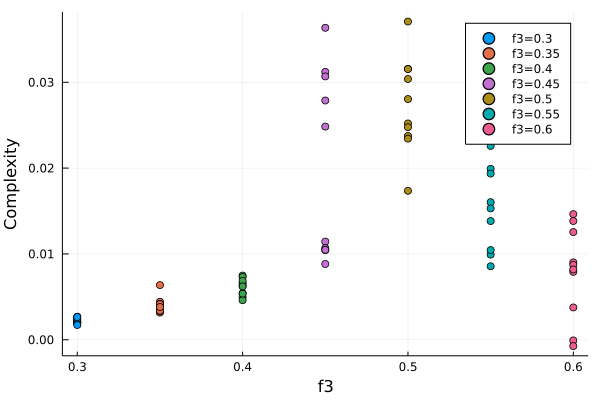

In [6]:
# scatter(f3s, mean.(compl), yerr=std.(compl)./sqrt(navg), label="Complexity")
pl = Plots.Plot()
xlabel!(pl, "f3")
ylabel!(pl, "Complexity")
for (i,f3) in pairs(f3s)
    scatter!(pl, f3*ones(navg), compl[i], label="f3=$f3")
end
pl

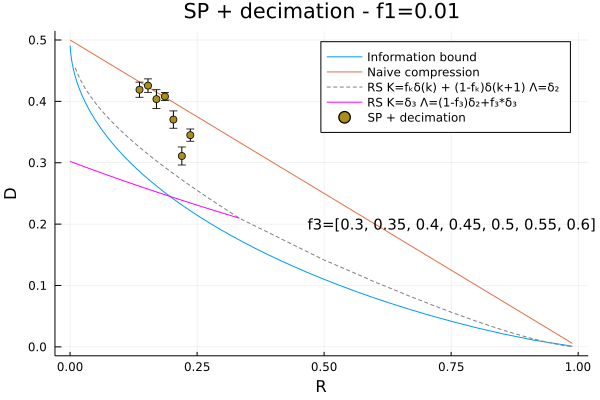

In [7]:
plot_rdb()
scatter!(Rs, D_avg, yerr=D_std, label="SP + decimation")
annotate!(0.75,0.2,Plots.text("f3="*string(collect(f3s)),10))
title!("SP + decimation - f1=$f1")

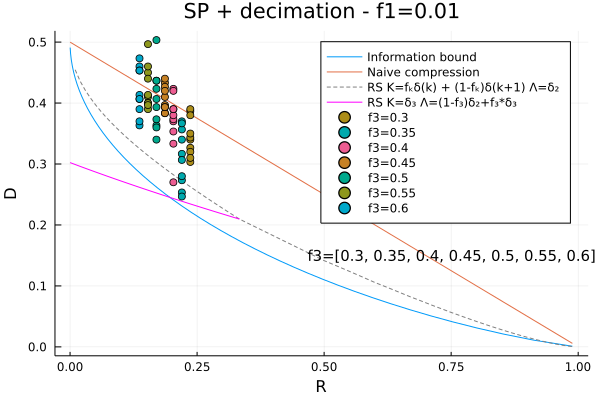

In [8]:
D_post = deepcopy(compl)
plot_rdb()
for (i,f3) in pairs(f3s)
    d = zeros(length(D_sp[i]))
    for k in 1:length(d)
        x0 = sources[i][k]
        sp = sps_post[i][k]
        mag = sign.(map(p->p'eachindex(p), sp.survey))
        x = mag .== -1
        B,indep = findbasis_slow(Array(sp.H))
        w = sparse(B*x[indep] .% 2)
        d[k] = mean(w .!= x0)
    end
    D_post[i] .= d
    scatter!(Rs[i]*ones(length(d)), d, label="f3=$f3")
end
annotate!(0.75,0.15,Plots.text("f3="*string(collect(f3s)),10))
title!("SP + decimation - f1=$f1")

Points for f3=0.35


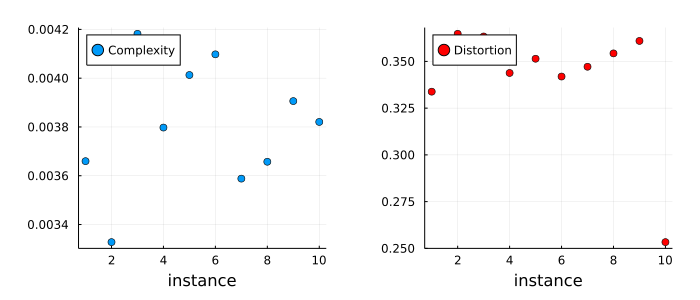

In [101]:
i = 2
# perm = sortperm(D_post[i])
perm = 1:navg
p1 = scatter(1:navg, compl[i][perm], label="Complexity", legend=:topleft, xlabel="instance")
p2 = scatter(1:navg, D_post[i][perm], c=:red, label="Distortion", legend=:topleft, xlabel="instance")
println("Points for f3=", f3s[i])
plot(p1,p2, size=(700,300), margin=5Plots.mm)

In [147]:
n = 2100
f1 = 0.01
f3 = 0.4
Λ = OffsetVector([0,f1,1-f1-f3,f3], 0:3)
K = OffsetVector([0,0,0,1], 0:3)
mK = sum(k*K[k] for k=eachindex(K))
mΛ = sum(d*Λ[d] for d=eachindex(Λ))
α = mΛ/mK; R = 1-α
# Single instance
nedges = Int(round(n*sum(i*l for (i,l) in pairs(Λ)), digits=8))
m = Int(nedges/3)
Ht = ldpc_matrix(n, m, nedges, Λ, K)
H = permutedims(Ht)
B,indep = findbasis(H, Ht)
x0 = bitrand(size(H,2))
s = (-1) .^ x0
init = OffsetArray(MVector{2J+1}(fill(0.0,2J+1)), -J:J)
init[-1:1] .= 1/3
sp = survey_propagation(H; field=copy(s), init, y=y);

In [148]:
decimate!(sp, indep; decsteps=1)

In [149]:
mag = sign.(map(p->p'eachindex(p), sp.survey))
x = mag .== -1
w = sparse(B*x[indep] .% 2);

In [150]:
dist = mean(w .!= x0)
R, dist

(0.20333333333333325, 0.2661904761904762)

In [52]:
plot_rdb()
scatter!([R], [dist], label="SP+decimation. f3=$f3, f1=$f1")

LoadError: UndefVarError: R not defined

In [219]:
function callback(t, ε, sp)
    t % 10 != 0 && return false
    mag = map(p->p'sign.(eachindex(p)), sp.survey)
    x = Vector(mag .< 0)
    x1 = (B*x[indep]) .% 2
    check = sum(H*x .%2)
    println("$t $check $(sum(x .!= x0)/length(x)) $(sum(x1 .!= x0)/length(x))")
    return check == 0
end
iteration!(sp, maxiter=100000, tol=1e-5, damp=0.2, rein=0.1, callback=callback)

10 281 0.202 0.2833333333333333
20 262 0.20477777777777778 0.27844444444444444
30 236 0.20666666666666667 0.2713333333333333
40 239 0.207 0.27444444444444444
50 215 0.20966666666666667 0.27155555555555555
60 207 0.21 0.27044444444444443
70 199 0.21166666666666667 0.2728888888888889
80 188 0.21244444444444444 0.2693333333333333
90 167 0.21266666666666667 0.27055555555555555
100 170 0.21222222222222223 0.27255555555555555
110 165 0.2127777777777778 0.2688888888888889
120 160 0.2137777777777778 0.2703333333333333
130 142 0.21555555555555556 0.26944444444444443
140 140 0.21544444444444444 0.2653333333333333
150 133 0.21644444444444444 0.2657777777777778
160 133 0.21755555555555556 0.2598888888888889
170 111 0.219 0.259
180 97 0.22022222222222224 0.25733333333333336
190 77 0.2212222222222222 0.25266666666666665
200 77 0.22155555555555556 0.24988888888888888
210 62 0.22233333333333333 0.247
220 73 0.222 0.24855555555555556
230 72 0.22211111111111112 0.2511111111111111
240 67 0.223 0.25111111

In [206]:
mag = map(p->p'eachindex(p), sp.survey);
x = Vector(mag .< 0)
xbase = B*(x[indep]) .% 2;

In [207]:
all(sign.(mag[indep]) == sign.(sp.efield[indep])) 

false

In [208]:
@show sum(x .!= x0)/length(xbase) 
@show sum(H*x .% 2)
@show sum(xbase .!= x0)/length(xbase)
@show sum(H*xbase .%2)/size(H,1)

sum(x .!= x0) / length(xbase) = 0.2058888888888889
sum((H * x) .% 2) = 235
sum(xbase .!= x0) / length(xbase) = 0.26766666666666666
sum((H * xbase) .% 2) / size(H, 1) = 0.0


0.0

In [209]:
sum(p[begin] for p in sp.survey)

2.2417460331495522e-69

In [128]:
[p[[-sp.J,sp.J]] for p in sp.survey[indep]]

2405-element Vector{Vector{Float64}}:
 [0.0, 1.0]
 [0.0, 1.0]
 [0.0, 1.0]
 [1.0, 0.0]
 [1.0, 0.0]
 [1.0, 0.0]
 [0.0, 1.0]
 [0.0, 1.0]
 [1.0, 0.0]
 [0.0, 1.0]
 [1.0, 0.0]
 [1.0, 0.0]
 [0.0, 1.0]
 ⋮
 [1.0, 0.0]
 [0.0, 1.0]
 [1.0, 0.0]
 [0.0, 1.0]
 [0.0, 1.0]
 [1.0, 0.0]
 [0.0, 1.0]
 [0.0, 1.0]
 [0.0, 1.0]
 [0.0, 1.0]
 [1.0, 0.0]
 [0.0, 1.0]

In [27]:
using ProgressMeter
callback(t,fg) = nothing;#println("$t $(fg.belief[1:4])")

nsamples = 10
fg = maxsum(H,  1 .- 2y .+ 1e-8*randn(N));

# the mapping is (0,1)=>(1,-1)
dist = map(1:nsamples) do i
    y = rand((0,1), N)
    fg.M .= 0
    fg.efield .= 1 .- 2y .+ 1e-8*randn(N)
    iteration!(fg; maxiter=2000, γ=1e-3, callback=callback)
    x = Int.(fg.belief .< 0)
    c = sum(fg.H'x .% 2)
    d = sum(x .⊻ y)/N
    @show d c
    x1 = B*x[indep] .% 2; d1 = sum(x1 .⊻ y)/N; c1 = sum(fg.H'x1 .% 2); @show d1 c1 
    d1
end
sum(dist)/nsamples

LoadError: UndefVarError: y not defined

In [28]:
1-M/N,sum(dist)/nsamples

LoadError: UndefVarError: dist not defined

In [29]:
x=[1:10;]; f=(x .% 2 .== 1);x[findall(f)]==x[f]

true

In [52]:
dist = map(1:10) do i
    Random.seed!(i)
    
    y = rand((0,1), N)

    lm = LossyModelGF2(fg, zeros(N), Inf, 1.0, y)
    
    function checker()
        v = (B*((fg.fields .< 0)[indep])) .% 2;
        dist = sum(v .⊻ y)/N
        check = sum(H*(fg.fields .< 0) .% 2)
        check, dist
    end

    independent = falses(N)
    independent[indep] .= true
    res_fg = solve!(lm, fg, randseed=1, verbose=true, showprogress=true, 
        independent=independent, basis = B)
#    res_fg = solve!(lm, fg, randseed=1, verbose=true, showprogress=true)
    avg_dist = res_fg.distortion 
    check, dist = checker()
    @show dist check avg_dist
    dist
end

Trial 1/1 100%|█████████████████████████████████████████| Time: 0:00:01


dist = 0.24287749287749288
check = 1
avg_dist = 0.4309116809116809


Trial 1/1 100%|█████████████████████████████████████████| Time: 0:00:01


dist = 0.24786324786324787
check = 1
avg_dist = 0.4309116809116809


Trial 1/1 100%|█████████████████████████████████████████| Time: 0:00:01


dist = 0.25427350427350426
check = 1
avg_dist = 0.4537037037037037


Trial 1/1 100%|█████████████████████████████████████████| Time: 0:00:01


dist = 0.26495726495726496
check = 5
avg_dist = 0.4565527065527066


Trial 1/1 100%|█████████████████████████████████████████| Time: 0:00:01


dist = 0.2378917378917379
check = 1
avg_dist = 0.42592592592592593


Trial 1/1 100%|█████████████████████████████████████████| Time: 0:00:01


dist = 0.26851851851851855
check = 4
avg_dist = 0.4423076923076923


Trial 1/1 100%|█████████████████████████████████████████| Time: 0:00:01


dist = 0.245014245014245
check = 6
avg_dist = 0.4458689458689459
dist = 0.24715099715099714
check = 0
avg_dist = 0.24715099715099714


Trial 1/1 100%|█████████████████████████████████████████| Time: 0:00:01


dist = 0.25427350427350426
check = 2
avg_dist = 0.44515669515669515
dist = 0.24857549857549857
check = 0
avg_dist = 0.24857549857549857


10-element Vector{Float64}:
 0.24287749287749288
 0.24786324786324787
 0.25427350427350426
 0.26495726495726496
 0.2378917378917379
 0.26851851851851855
 0.245014245014245
 0.24715099715099714
 0.25427350427350426
 0.24857549857549857

In [53]:
dev = sqrt(sum(dist.^2)/length(dist)-(sum(dist)/length(dist))^2)/sqrt(length(dist))
1-M/N, sum(dist)/length(dist)

(0.24002849002849003, 0.2511396011396011)